In [1]:
import time, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, optimizers
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
CSV_PATH   = "ALL_MERGED.csv"   # set to your merged dataset
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

# Best GRU params you’ve been using (change if your Optuna best differs)
BEST_PARAMS = {
    "lookback": 30,
    "batch_size": 32,
    "epochs": 40,
    "patience": 7,
    "units": 256,
    "dropout": 0.28,
    "lr": 1.35e-3,
}

# Laplace settings
PRIOR_VAR = 5      # prior variance on last-layer weights (λ = 1/PRIOR_VAR)
USE_TRAINVAL_FOR_LAPLACE = True  # True: use train+val to form Σ_w; False: train only
Z_CI = 1.959963984540054  # 95% Normal quantile (two-sided)
ROLL_WIN = 30

RANDOM_SEED = 31415
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

In [3]:
df = pd.read_csv(CSV_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()

required = [
    "Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

n = len(df)
test_n = int(np.floor(TEST_SIZE*n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE*trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n+val_n].copy()
test_df  = df.iloc[train_n+val_n:].copy()

if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
print(f"Feature columns: {feature_cols}")

Feature columns: ['Nickel_Fut', 'Coal_Fut_Newcastle', 'Palm_Oil_Fut', 'USD_IDR', 'CNY_IDR', 'EUR_IDR', 'BTC_USD', 'FTSE100', 'HANGSENG', 'NIKKEI225', 'SNP500', 'DOW30', 'SSE_Composite', 'JKSE']


In [4]:
# ----------------- Scale --------------------------------------------------------
X_scaler = StandardScaler().fit(train_df[feature_cols])
y_scaler = StandardScaler().fit(train_df[[TARGET_COL]])
y_mean = float(y_scaler.mean_[0])
y_std  = float(np.sqrt(y_scaler.var_[0]))

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i-lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])
    return np.array(X_list, dtype=np.float32), np.array(y_list, dtype=np.float32), np.array(idx_list)

LB = BEST_PARAMS["lookback"]
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, LB)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   LB)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  LB)

In [5]:
# ----------------- Heteroscedastic Gaussian NLL --------------------------------
# Model: trunk -> features φ(x); two heads:
#   mu_head: Dense(1) linear (this is the layer we put Laplace on)
#   log_var_head: Dense(1) (predict log σ_ale^2)
def nll_gaussian(y_true, y_pred):
    # y_pred = concat([mu, log_var])
    mu = y_pred[:, 0:1]
    log_var = y_pred[:, 1:2]           # log σ^2
    inv_var = tf.exp(-log_var)
    # NLL up to const: 0.5*( (y-mu)^2 / σ^2 + log σ^2 )
    return tf.reduce_mean(0.5 * (tf.square(y_true - mu) * inv_var + log_var))

def build_hetero_gru(n_features):
    x_in = Input(shape=(LB, n_features))
    h = GRU(BEST_PARAMS["units"])(x_in)
    h = Dropout(BEST_PARAMS["dropout"])(h)
    # two heads
    mu = Dense(1, name="mu")(h)
    log_var = Dense(1, name="log_var")(h)  # unconstrained; σ^2 = exp(log_var)
    y_out = tf.keras.layers.Concatenate(name="out")([mu, log_var])
    model = Model(inputs=x_in, outputs=y_out, name="GRU_HeteroNLL")
    opt = optimizers.Adam(learning_rate=BEST_PARAMS["lr"])
    model.compile(optimizer=opt, loss=nll_gaussian)
    # a second model to extract features φ(x) (the 'h' vector before mu/log_var)
    feat_model = Model(inputs=x_in, outputs=h, name="feature_extractor")
    return model, feat_model

model, feat_model = build_hetero_gru(n_features=len(feature_cols))

callbacks = [
    # EarlyStopping(monitor="val_loss", patience=BEST_PARAMS["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/gru_hetero_best.keras", save_best_only=True, monitor="val_loss")
]

print("\nTraining GRU (Heteroscedastic NLL)...")
t0 = time.time()
hist = model.fit(
    X_train_w, y_train_w.reshape(-1,1),
    validation_data=(X_val_w, y_val_w.reshape(-1,1)),
    epochs=BEST_PARAMS["epochs"],
    batch_size=BEST_PARAMS["batch_size"],
    verbose=1,
    callbacks=callbacks
)
print(f"Training time: {time.time()-t0:.2f}s")


Training GRU (Heteroscedastic NLL)...
Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: -0.3801 - val_loss: -0.7678
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -1.2147 - val_loss: -1.5640
Epoch 3/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -1.4492 - val_loss: -1.2459
Epoch 4/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -1.5791 - val_loss: -1.6584
Epoch 5/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -1.6649 - val_loss: -1.6495
Epoch 6/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -1.6983 - val_loss: -1.7473
Epoch 7/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -1.7029 - val_loss: -1.9088
Epoch 8/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -1.8134 - val_loss: -2.1653
Epoch 9/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -1.8207 - val_loss: -2.0077
Epoch 10/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -1.8901 - val_loss: -1.5582
Epoch 11/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -1.7823 - val_loss: -1.9266
Ep

In [6]:
# ----------------- Get heads on windows (std scale) ----------------------------
def predict_mu_logvar(model, X, idx):
    pred = model.predict(X, verbose=0)
    mu = pred[:, 0]
    log_var = pred[:, 1]
    sigma2_ale_std = np.exp(log_var)             # on standardized y-scale
    # map μ back to original scale
    mu_orig = mu * y_std + y_mean
    # aleatoric variance back to original scale (variance scales by y_std^2)
    sigma2_ale_orig = sigma2_ale_std * (y_std**2)
    return (pd.Series(mu_orig, index=idx, name="mu"),
            pd.Series(sigma2_ale_orig, index=idx, name="ale_var"),
            pd.Series(mu, index=idx, name="mu_std"),
            pd.Series(sigma2_ale_std, index=idx, name="ale_var_std"))

mu_tr, ale_tr, mu_tr_std, ale_tr_std = predict_mu_logvar(model, X_train_w, idx_train)
mu_va, ale_va, mu_va_std, ale_va_std = predict_mu_logvar(model, X_val_w,   idx_val)
mu_te, ale_te, mu_te_std, ale_te_std = predict_mu_logvar(model, X_test_w,  idx_test)


In [7]:
# ----------------- Last-Layer Laplace on μ-head --------------------------------
# We only place a Gaussian posterior on the last μ Dense layer weights.
# For Dense(1): y_mu = φ^T w + b. We fold bias into weights by appending a 1 to φ.
# Σ_w = (λ I + Σ_i (1/σ_i^2) φ_i φ_i^T)^{-1}, where σ_i^2 is aleatoric variance (std-scale!)
lambda_prior = 1.0 / PRIOR_VAR

# Choose data for Laplace: train or train+val
if USE_TRAINVAL_FOR_LAPLACE:
    X_lap = np.concatenate([X_train_w, X_val_w], axis=0)
    idx_lap = np.concatenate([idx_train, idx_val], axis=0)
else:
    X_lap = X_train_w
    idx_lap = idx_train

# Extract features φ(x)
Phi_core = feat_model.predict(X_lap, verbose=0)          # shape [N, H]
N, H = Phi_core.shape
Phi = np.concatenate([Phi_core, np.ones((N,1))], axis=1)  # fold bias; shape [N, H+1]

# Per-sample aleatoric variance on std scale for Laplace weights
# (we use the model's current σ^2_ale predictions)
_, _, _, ale_lap_std = predict_mu_logvar(model, X_lap, idx_lap)
sigma2_i = ale_lap_std.values.reshape(-1, 1)              # [N,1]
w_i = 1.0 / (sigma2_i + 1e-12)                            # weights

# Compute A = λI + Φ^T W Φ, where W = diag(w_i)
# Efficiently: Φ^T (W Φ) = (Φ * w_i).T @ Φ
Phi_weighted = Phi * w_i
A = lambda_prior * np.eye(H+1) + Phi.T @ Phi_weighted     # (H+1) x (H+1)

# Posterior covariance Σ_w = A^{-1}
# (We won't form full inverse explicitly for stability; we’ll solve with A later.)
# Get current μ-head weights (last Dense layer)
mu_layer = model.get_layer("mu")
W_mu, b_mu = mu_layer.get_weights()   # W_mu: [H,1], b_mu: [1]
w_hat = np.vstack([W_mu, [[b_mu.item()]]])  # (H+1,1)

In [8]:
# --------------- Predictive decomposition on any X: μ, σ_ale^2, σ_epi^2 --------
def predict_with_laplace(X, idx):
    # heads
    pred = model.predict(X, verbose=0)
    mu_std = pred[:, 0:1]                   # [N,1] std-scale μ
    log_var = pred[:, 1:2]
    sigma2_ale_std = np.exp(log_var)        # [N,1] std-scale aleatoric variance

    # features φ(x)
    Phi_core = feat_model.predict(X, verbose=0)     # [N,H]
    Phi_aug = np.concatenate([Phi_core, np.ones((len(X),1))], axis=1)  # [N,H+1]

    # epistemic variance: diag(Φ Σ_w Φ^T) via solving A x = Φ^T for each row
    # We compute v_epi = sum_j φ_j * s_j where s = solve(A, φ) then φ^T s
    # Vectorized trick: solve A * S = Φ_aug^T  -> S = A^{-1} Φ^T ; then diag(Φ S)
    S = np.linalg.solve(A, Phi_aug.T)                 # (H+1, H+1) * (H+1, N) -> (H+1, N)
    v_epi_std = np.einsum('ij,ji->i', Phi_aug, S)     # diag(Φ * S) -> [N]
    v_epi_std = v_epi_std.reshape(-1,1)

    # total variance (std scale) and map to original scale
    sigma2_tot_std = sigma2_ale_std + v_epi_std
    mu_orig = mu_std * y_std + y_mean
    sigma2_ale_orig = sigma2_ale_std * (y_std**2)
    sigma2_epi_orig = v_epi_std * (y_std**2)
    sigma2_tot_orig = sigma2_ale_orig + sigma2_epi_orig

    return (pd.Series(mu_orig.squeeze(), index=idx, name="mu"),
            pd.Series(sigma2_ale_orig.squeeze(), index=idx, name="ale_var"),
            pd.Series(sigma2_epi_orig.squeeze(), index=idx, name="epi_var"),
            pd.Series(sigma2_tot_orig.squeeze(), index=idx, name="tot_var"))

mu_tr_l, ale_tr_l, epi_tr_l, tot_tr_l = predict_with_laplace(X_train_w, idx_train)
mu_va_l, ale_va_l, epi_va_l, tot_va_l = predict_with_laplace(X_val_w,   idx_val)
mu_te_l, ale_te_l, epi_te_l, tot_te_l = predict_with_laplace(X_test_w,  idx_test)

def make_pi(mu, var_tot, z=Z_CI):
    std = np.sqrt(var_tot.values)
    L = mu.values - z*std
    U = mu.values + z*std
    return pd.Series(L, index=mu.index, name="L"), pd.Series(U, index=mu.index, name="U")

L_tr, U_tr = make_pi(mu_tr_l, tot_tr_l)
L_va, U_va = make_pi(mu_va_l, tot_va_l)
L_te, U_te = make_pi(mu_te_l, tot_te_l)

In [9]:
# ----------------- Metrics ------------------------------------------------------
actual = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

def base_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return mse, mae, rmse, mape, r2

def interval_metrics(y_true, L, U, alpha=0.05):
    y = y_true.values; Lv = L.values; Uv = U.values
    inside = (y >= Lv) & (y <= Uv)
    picp = inside.mean()
    mpiw = np.mean(Uv - Lv)
    W = np.where(
        inside,
        (Uv - Lv),
        np.where(y < Lv, (Uv - Lv) + (2.0/alpha)*(Lv - y),
                 (Uv - Lv) + (2.0/alpha)*(y - Uv))
    )
    wink = np.mean(W)
    # tri-state label: -1 below, 0 inside, +1 above
    tri = np.full_like(y, 0, dtype=int)
    tri[y < Lv] = -1
    tri[y > Uv] = +1
    tri_s = pd.Series(tri, index=y_true.index, name="coverage_state")
    return picp, mpiw, wink, pd.Series(inside.astype(int), index=y_true.index, name="Covered"), tri_s

m_train = base_metrics(actual_train, mu_tr_l); m_val = base_metrics(actual_val, mu_va_l); m_test = base_metrics(actual_test, mu_te_l)
picp_tr, mpiw_tr, wink_tr, covered_tr, tri_tr = interval_metrics(actual_train, L_tr, U_tr, alpha=0.05)
picp_va, mpiw_va, wink_va, covered_va, tri_va = interval_metrics(actual_val,   L_va, U_va, alpha=0.05)
picp_te, mpiw_te, wink_te, covered_te, tri_te = interval_metrics(actual_test,  L_te, U_te, alpha=0.05)

metrics_df = pd.DataFrame(
    [
        [*m_train, picp_tr, mpiw_tr, wink_tr],
        [*m_val,   picp_va, mpiw_va, wink_va],
        [*m_test,  picp_te, mpiw_te, wink_te],
    ],
    columns=["MSE","MAE","RMSE","MAPE","R²","PICP","MPIW","Winkler"],
    index=["Train","Validation","Test"]
)
pd.set_option("display.float_format", "{:.5f}".format)
print("\n=== Metrics Summary — Hetero GRU + LLLA ===")
print(metrics_df)



=== Metrics Summary — Hetero GRU + LLLA ===
                   MSE       MAE      RMSE    MAPE      R²    PICP      MPIW  \
Train       2087.53593  30.89263  45.68956 0.00550 0.99584 0.97156 230.02146   
Validation  2791.92124  40.63621  52.83863 0.00583 0.89699 0.98855 265.65113   
Test       21868.60430 126.44762 147.88037 0.01755 0.80599 0.99857 678.53627   

             Winkler  
Train      267.81207  
Validation 276.57304  
Test       685.08388  


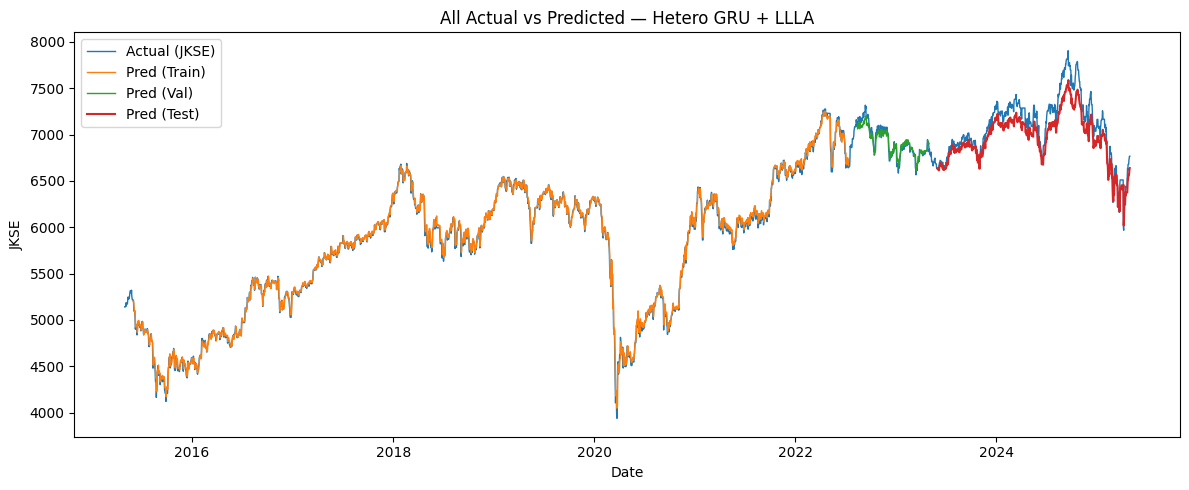

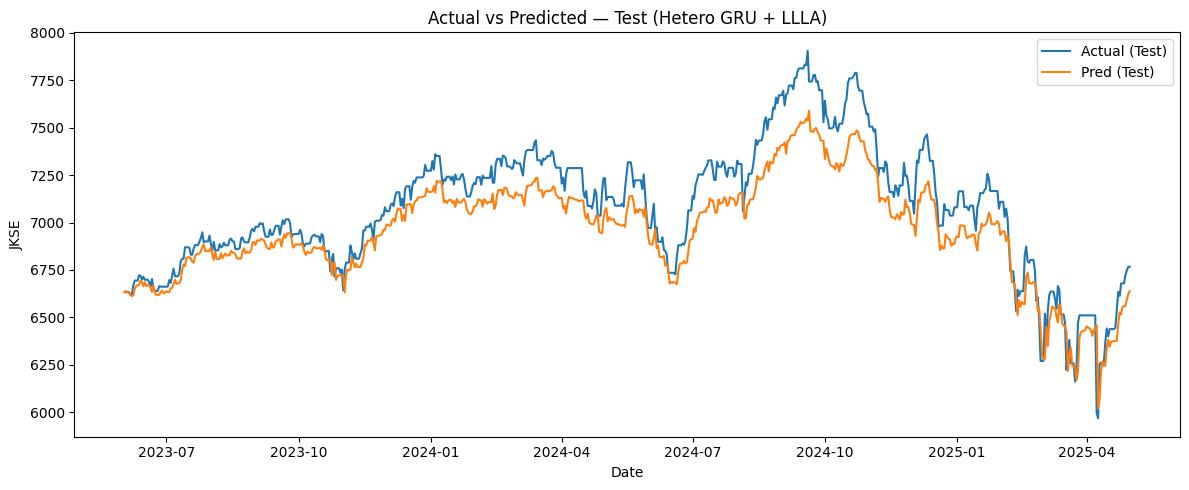

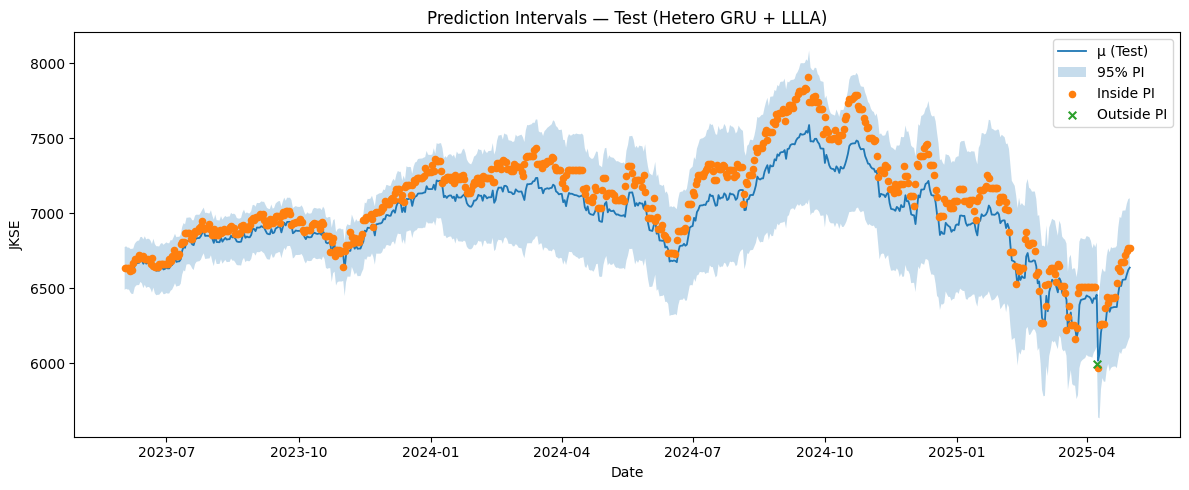

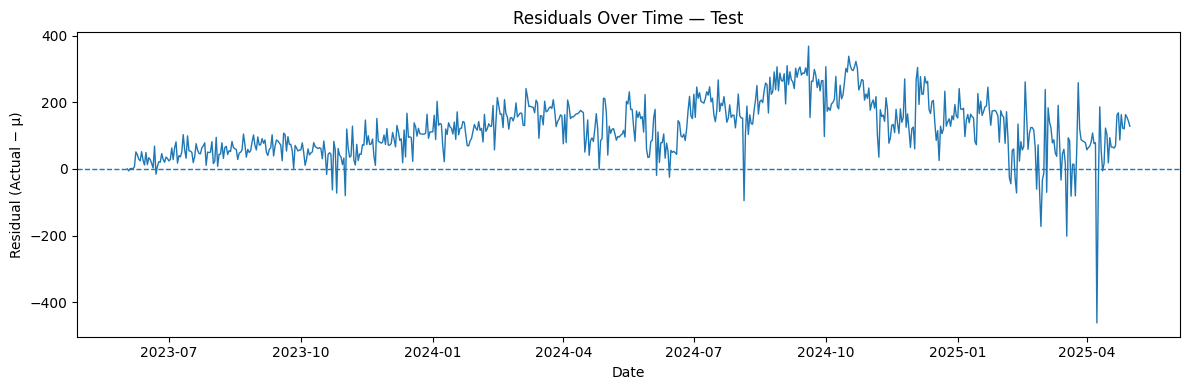

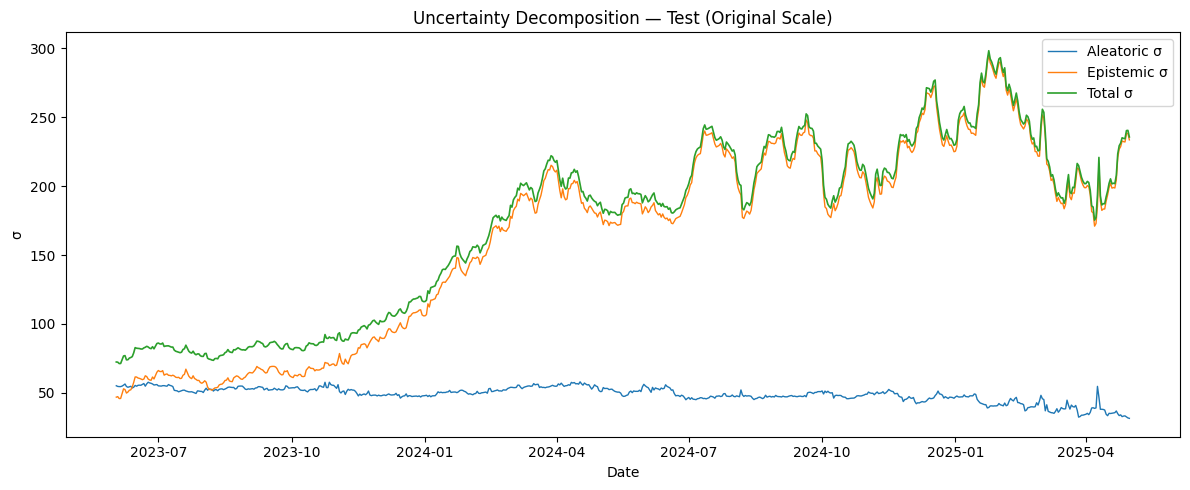

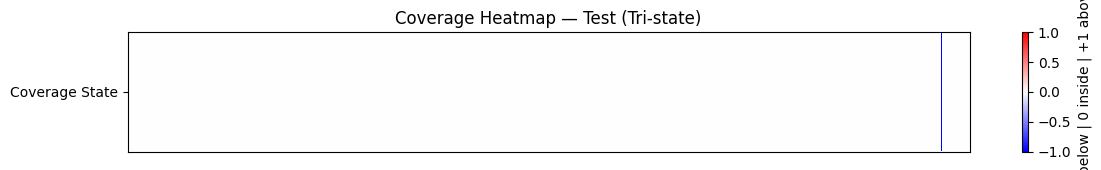

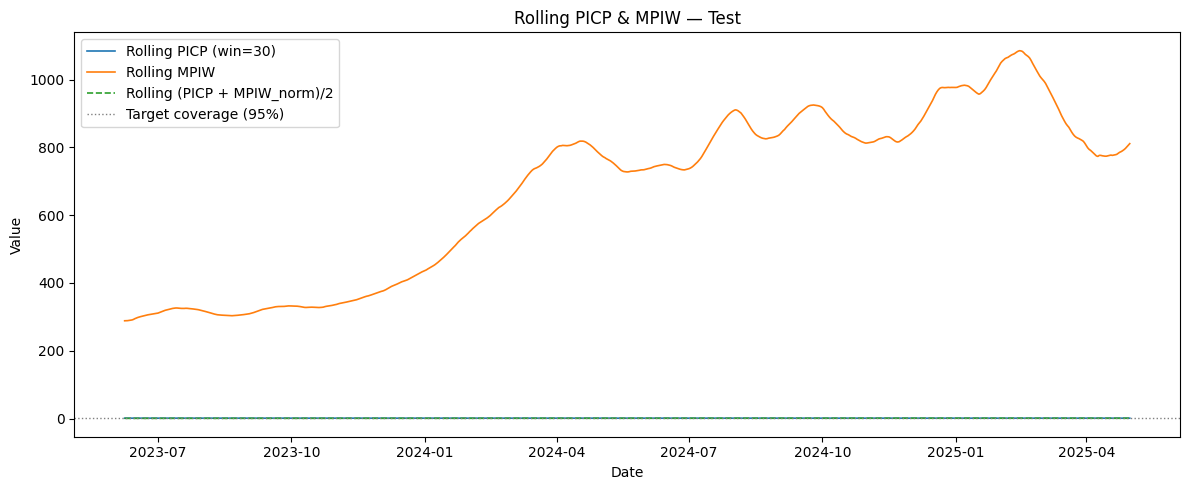

In [10]:
# ----------------- Visualizations ----------------------------------------------
# (1) All data vs predict train/val/test
plt.figure(figsize=(12,5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(mu_tr_l.index, mu_tr_l.values, label="Pred (Train)", linewidth=1)
plt.plot(mu_va_l.index, mu_va_l.values, label="Pred (Val)", linewidth=1)
plt.plot(mu_te_l.index, mu_te_l.values, label="Pred (Test)", linewidth=1.5)
plt.title("All Actual vs Predicted — Hetero GRU + LLLA")
plt.xlabel("Date"); plt.ylabel("JKSE"); plt.legend(); plt.tight_layout(); plt.show()

# (2) Only actual vs test predicted
plt.figure(figsize=(12,5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mu_te_l.index,    mu_te_l.values,    label="Pred (Test)", linewidth=1.5)
plt.title("Actual vs Predicted — Test (Hetero GRU + LLLA)")
plt.xlabel("Date"); plt.ylabel("JKSE"); plt.legend(); plt.tight_layout(); plt.show()

# (3) PI with scatter: green bullets if inside, red crosses if outside
plt.figure(figsize=(12,5))
plt.plot(mu_te_l.index, mu_te_l.values, label="μ (Test)", linewidth=1.3)
plt.fill_between(mu_te_l.index, L_te.values, U_te.values, alpha=0.25, label="95% PI")
# scatter annotations
inside_mask = covered_te.astype(bool).values
x_dates = actual_test.index
plt.scatter(x_dates[inside_mask], actual_test.values[inside_mask], s=20, marker='o', label="Inside PI", zorder=3)
plt.scatter(x_dates[~inside_mask], actual_test.values[~inside_mask], s=30, marker='x', label="Outside PI", zorder=3)
plt.title("Prediction Intervals — Test (Hetero GRU + LLLA)")
plt.xlabel("Date"); plt.ylabel("JKSE"); plt.legend(); plt.tight_layout(); plt.show()

# (4) Residuals over time
resid_te = pd.Series(actual_test.values - mu_te_l.values, index=actual_test.index, name="Residual")
plt.figure(figsize=(12,4))
plt.plot(resid_te.index, resid_te.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time — Test")
plt.xlabel("Date"); plt.ylabel("Residual (Actual − μ)"); plt.tight_layout(); plt.show()

# (5) Uncertainty decomposition over time
plt.figure(figsize=(12,5))
plt.plot(ale_te_l.index, np.sqrt(ale_te_l.values), label="Aleatoric σ", linewidth=1)
plt.plot(epi_te_l.index, np.sqrt(epi_te_l.values), label="Epistemic σ", linewidth=1)
plt.plot(tot_te_l.index, np.sqrt(tot_te_l.values), label="Total σ", linewidth=1.2)
plt.title("Uncertainty Decomposition — Test (Original Scale)")
plt.xlabel("Date"); plt.ylabel("σ"); plt.legend(); plt.tight_layout(); plt.show()

# (6) Coverage heatmap (tri-state: -1 below, 0 inside, +1 above)
tri_vals = tri_te.values.reshape(1, -1)  # 1 x T
plt.figure(figsize=(12,1.8))
im = plt.imshow(tri_vals, aspect='auto', interpolation='nearest', vmin=-1, vmax=1, cmap='bwr')  # blue(-1) white(0) red(+1)
plt.yticks([0], ["Coverage State"])
plt.xticks([]); plt.colorbar(label="−1 below | 0 inside | +1 above")
plt.title("Coverage Heatmap — Test (Tri-state)")
plt.tight_layout(); plt.show()

# (7) Rolling PICP, MPIW, and combined PICP+MPIW_norm
def rolling(series, win):
    return series.rolling(win, min_periods=max(5, win//4)).mean()

cov_series = covered_te.astype(float)
width_series = (U_te - L_te)

plt.figure(figsize=(12,5))
plt.plot(rolling(cov_series, ROLL_WIN), label=f"Rolling PICP (win={ROLL_WIN})", linewidth=1.2)
plt.plot(rolling(width_series, ROLL_WIN), label="Rolling MPIW", linewidth=1.2)
mpiw_norm = (rolling(width_series, ROLL_WIN) - width_series.min()) / (width_series.max()-width_series.min() + 1e-12)
combo = (rolling(cov_series, ROLL_WIN) + mpiw_norm)/2.0
plt.plot(combo, label="Rolling (PICP + MPIW_norm)/2", linestyle="--", linewidth=1.2)
plt.axhline(0.95, color='gray', linestyle=':', linewidth=1, label="Target coverage (95%)")
plt.title("Rolling PICP & MPIW — Test")
plt.xlabel("Date"); plt.ylabel("Value"); plt.legend(); plt.tight_layout(); plt.show()
